# Detecting Hearbeat Anomalies


> In this tutorial, you'll learn how to create an `LSTM Autoencoder` with PyTorch and use it to detect heartbeat anomalies in ECG data.

**Summary of notebook**

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

**NOTE** *While our Time Series data is univariate (we have only 1 feature), the code should work for multivariate datasets (multiple features) with little or no modification. Feel free to try it!*


In [16]:
from typing import Any, Dict, Iterable, List, Optional, Tuple
from copy import deepcopy
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
import mplcyberpunk
import matplotlib.pyplot as plt
plt.style.use('cyberpunk')

In [2]:
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from scipy.io.arff import loadarff
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
SEED = 42
COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
def arff_to_df(fp: str) -> DataFrame:
    data, meta = loadarff(fp)
    return DataFrame(data)

train = arff_to_df('ECG5000/ECG5000_TRAIN.arff')
test = arff_to_df('ECG5000/ECG5000_TEST.arff')
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [5]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,b'1'
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,b'1'
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,b'1'
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,b'1'
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,b'1'


In [6]:
classes = ['normal', 'r_on_t', 'pvc', 'sp', 'ub']

columns = list(df.columns)
columns[-1] = 'target'
df.columns = columns
df.target.value_counts()

b'1'    2919
b'2'    1767
b'4'     194
b'3'      96
b'5'      24
Name: target, dtype: int64

/home/ego/anaconda3/envs/finance/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


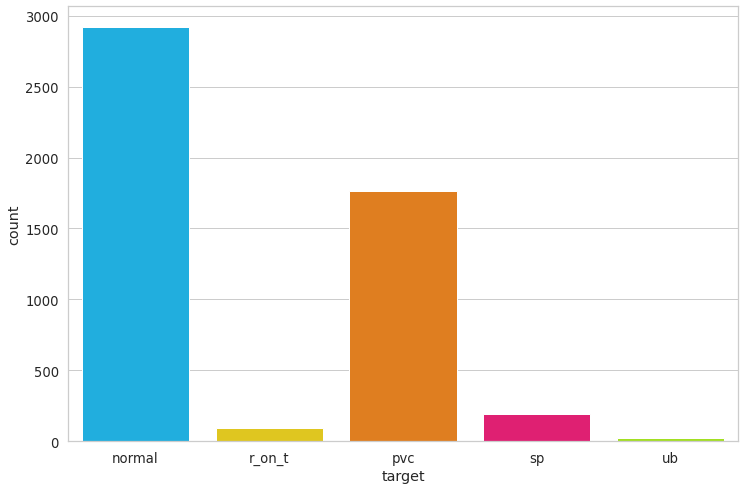

In [7]:
ax = sns.countplot(df.target)
ax.set_xticklabels(classes);

In [ ]:
# (optional) execute the following code to render charts in cyberpunk theme.
import mplcyberpunk
import matplotlib.pyplot as plt
plt.style.use('cyberpunk')

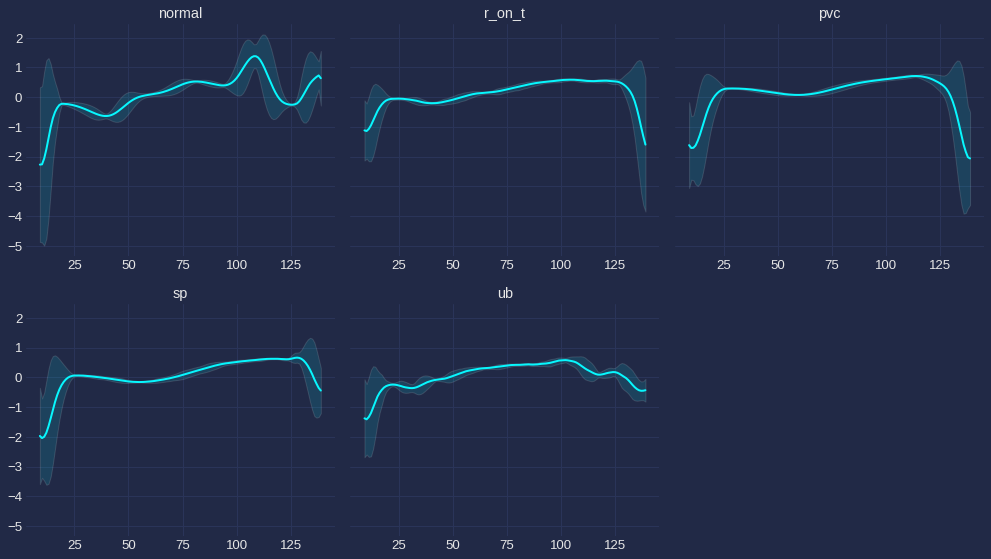

In [39]:
def ts_plot_(data, label, ax, steps=10) -> None:
    ts = DataFrame(data)
    smooth = ts.rolling(steps).mean()
    dev =  2 * ts.rolling(steps).std()
    underline = (smooth - dev)[0]
    overline = (smooth + dev)[0]
    ax.plot(smooth, linewidth=2)
    ax.fill_between(
        dev.index, underline, overline, alpha=.125)
    ax.set_title(label)

target_classes = df.target.unique()
fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)
for i, cls in enumerate(target_classes):
    ax = axs.flat[i]
    data = df[df.target == cls] \
        .drop(labels='target', axis=1).mean(axis=0).to_numpy() 
    ts_plot_(data, classes[i], ax=ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout()
plt.show()

> Normal vs Anomaly classes

- Split the dataframe into normal and anomaly subsets

In [9]:
NORMAL = b'1'
normal_df = df[df.target == NORMAL].drop(labels='target', axis=1)
anomaly_df = df[df.target != NORMAL].drop(labels='target', axis=1)

normal_df.shape, anomaly_df.shape

((2919, 140), (2081, 140))

In [10]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    return [torch.tensor(x).unsqueeze(1).float() for x in sequences]

train_df, valid_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=SEED
)
valid_df, test_df = train_test_split(
  valid_df,
  test_size=0.33, 
  random_state=SEED
)

train_ds = create_dataset(train_df)
valid_ds = create_dataset(valid_df)
test_normal_ds = create_dataset(test_df)
test_anomaly_ds = create_dataset(anomaly_df)

batch_size, seq_length, n_features = torch.stack(train_ds).shape
batch_size, seq_length, n_features

(2481, 140, 1)

### LSTM Autoencoder

> **Complexity Theory** - Adaptive centralized coordination of self-organization.

---

The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

- We'll use the LSTM Autoencoder from this [GitHub repo](https://github.com/shobrook/sequitur) with some small tweaks. Our model's job is to reconstruct Time Series data. Let's start with the *Encoder*

In [11]:
class Encoder(nn.Module):
    def __init__(self, seq_length: int, n_features: int, embed_dim=64) -> None:
        super(Encoder, self).__init__()
        self.seq_length = seq_length
        self.n_features = n_features
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim = embed_dim * 2
        self.rnn0 = nn.LSTM(n_features, hidden_dim,
                            num_layers=1, batch_first=True)
        self.rnn1 = nn.LSTM(hidden_dim, embed_dim,
                            num_layers=1, batch_first=True)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = input.reshape(1, self.seq_length, self.n_features)
        x, (_, _) = self.rnn0(x)
        # take the outputs from the hidden layer.
        _, (hidden, _) = self.rnn1(x)
        x = hidden.reshape((self.n_features, self.embed_dim))
        return x


class Decoder(nn.Module):
    def __init__(self, seq_length: int, input_dim=64, n_features=1) -> None:
        super(Decoder, self).__init__()
        self.seq_length = seq_length
        self.n_features = n_features
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim = input_dim * 2
        self.rnn0 = nn.LSTM(input_dim, input_dim,
                            num_layers=1, batch_first=True)
        self.rnn1 = nn.LSTM(input_dim, hidden_dim,
                            num_layers=1, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, n_features)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = input.repeat(self.seq_length, self.n_features)
        x = x.reshape((self.n_features, self.seq_length, self.input_dim))
        x, (_, _) = self.rnn0(x)
        x, (_, _) = self.rnn1(x)
        x = x.reshape((self.seq_length, self.hidden_dim))
        x = self.classifier(x)
        return x


class RecurrentAutoEncoder(nn.Module):
    def __init__(self, seq_length: int, n_features: int, embed_dim=64) -> None:
        super(RecurrentAutoEncoder, self).__init__()
        self.encoder = Encoder(seq_length, n_features, embed_dim)
        self.decoder = Decoder(seq_length, embed_dim, n_features)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.encoder(input)
        x = self.decoder(x)
        return x


def train(
    model: torch.nn.Module,
    train_dataset: Iterable,
    eval_dataset: Iterable,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    epochs: int = 150,
    device: Optional[Any] = None,
) -> Tuple[torch.nn.Module, Dict[str, List[float]]]:

    T = 'epoch: {}\t(x-loss): {:.4f}\t(y-loss): {:.4f}'
    if device is None:
        type = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = model.to(torch.device(type))
    history = dict(train=[], eval=[])
    best_model = deepcopy(model.state_dict())
    best_loss = 10000.0

    for epoch in range(1, epochs + 1):
        model = model.train()
        train_losses = []
        for input in train_dataset:
            input = input.to(device)
            optimizer.zero_grad()
            logits = model(input)
            loss = criterion(logits, input)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        eval_losses = []
        model = model.eval()
        with torch.no_grad():
            for input in eval_dataset:
                input = input.to(device)
                logits = model(input)
                loss = criterion(logits, input)
                eval_losses.append(loss.item())

        eval_loss = np.mean(eval_losses)
        train_loss = np.mean(train_losses)
        history['train'].append(train_loss)
        history['eval'].append(eval_loss)

        if eval_loss < best_loss:
            best_loss = eval_loss
            best_model = deepcopy(model.state_dict())
        print(T.format(epoch, train_loss, eval_loss))

    model.load_state_dict(best_model)
    return model.eval(), history


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RecurrentAutoEncoder(seq_length, n_features, 128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss(reduction='sum').to(device)

print(model)

RecurrentAutoEncoder(
  (encoder): Encoder(
    (rnn0): LSTM(1, 256, batch_first=True)
    (rnn1): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn0): LSTM(128, 128, batch_first=True)
    (rnn1): LSTM(128, 256, batch_first=True)
    (classifier): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [13]:
gold_model, history = train(
    model, train_ds, valid_ds, optimizer, criterion, epochs=150, device=device,
)

epoch: 1	(x-loss): 68.7128	(y-loss): 55.4788
epoch: 2	(x-loss): 55.2307	(y-loss): 55.4184
epoch: 3	(x-loss): 54.9743	(y-loss): 54.7384
epoch: 4	(x-loss): 54.8656	(y-loss): 54.5774
epoch: 5	(x-loss): 54.8121	(y-loss): 54.3295
epoch: 6	(x-loss): 54.7758	(y-loss): 54.1916
epoch: 7	(x-loss): 55.3416	(y-loss): 54.7334
epoch: 8	(x-loss): 54.8357	(y-loss): 52.3974
epoch: 9	(x-loss): 50.4062	(y-loss): 46.5804
epoch: 10	(x-loss): 51.8952	(y-loss): 54.5654
epoch: 11	(x-loss): 52.8244	(y-loss): 50.2708
epoch: 12	(x-loss): 49.2115	(y-loss): 46.3951
epoch: 13	(x-loss): 44.9247	(y-loss): 45.4937
epoch: 14	(x-loss): 38.7335	(y-loss): 42.1238
epoch: 15	(x-loss): 38.1330	(y-loss): 37.6346
epoch: 16	(x-loss): 39.4181	(y-loss): 35.8946
epoch: 17	(x-loss): 35.4035	(y-loss): 37.9063
epoch: 18	(x-loss): 32.3060	(y-loss): 33.8361
epoch: 19	(x-loss): 29.1904	(y-loss): 29.6324
epoch: 20	(x-loss): 28.3319	(y-loss): 26.4511
epoch: 21	(x-loss): 27.2075	(y-loss): 25.8036
epoch: 22	(x-loss): 26.2075	(y-loss): 24.88

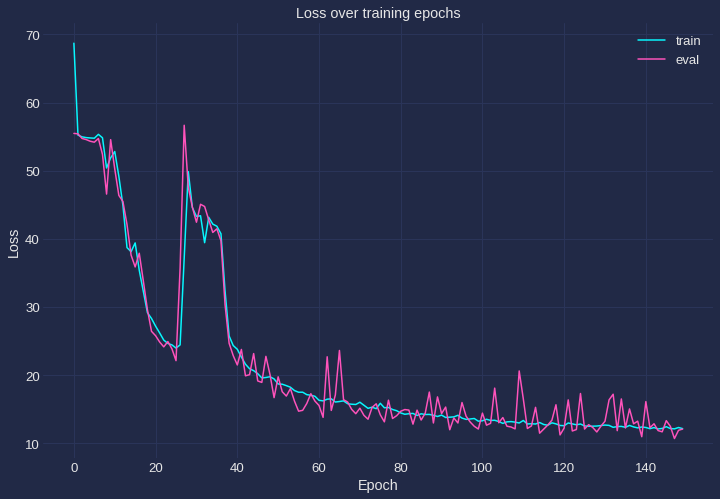

In [17]:
ax = plt.figure().gca()
ax.plot(history['train'])
ax.plot(history['eval'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'eval'])
plt.title('Loss over training epochs')
plt.show()

In [19]:
!mkdir pt-model
!ls

 ECG5000
 pt-model
'Time Series Anomaly Detection using LSTM Autoencoders with PyTorch.ipynb'


In [20]:
# Save the pretrained model for later use.
torch.save(gold_model, 'pt-model/model.pt')

### Threshold Choice

> Having our trained model we can now look at the reconstruction error on the training set. Let's start by writing a hlper function to get predictions from our model.

In [32]:
from typing import Callable

_T = Tuple[List[Any], List[Any]]

def load_prediction_fn(model, device) -> Callable[[Iterable], _T]:
    """Build a callable attached with the model and device. Takes an
    iterable dataset as the input and returns a tuple of iterables of
    the model's predictions and losses.
    """
    def function(dataset: Iterable, model=model, device=device) -> _T:
        preds, losses = [], []
        criterion = nn.L1Loss(reduction='sum').to(device)
        with torch.no_grad():
            model = model.eval()
            for input in dataset:
                input = input.to(device)
                logits = model(input)
                loss = criterion(logits, input)
                preds.append(logits.cpu().numpy().flatten())
                losses.append(loss.item())
        return preds, losses
    return function

/home/ego/anaconda3/envs/finance/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


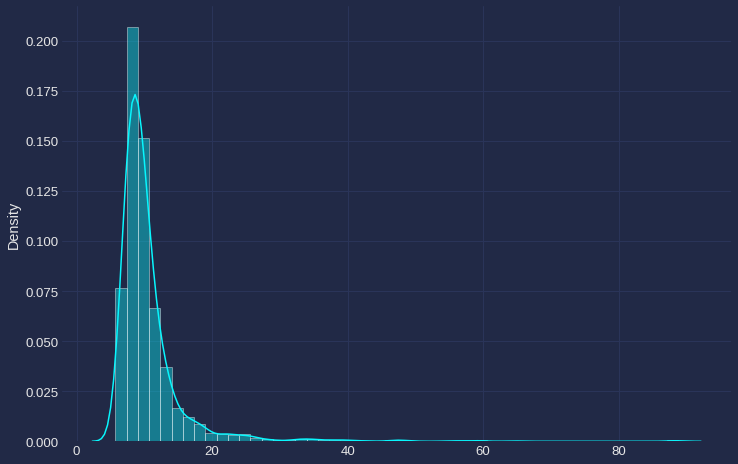

In [27]:
predict = load_prediction_fn(gold_model, device)

_, losses = predict(train_ds)
sns.distplot(losses, bins=50, kde=True);

## Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal hearbeats

> Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):

/home/ego/anaconda3/envs/finance/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


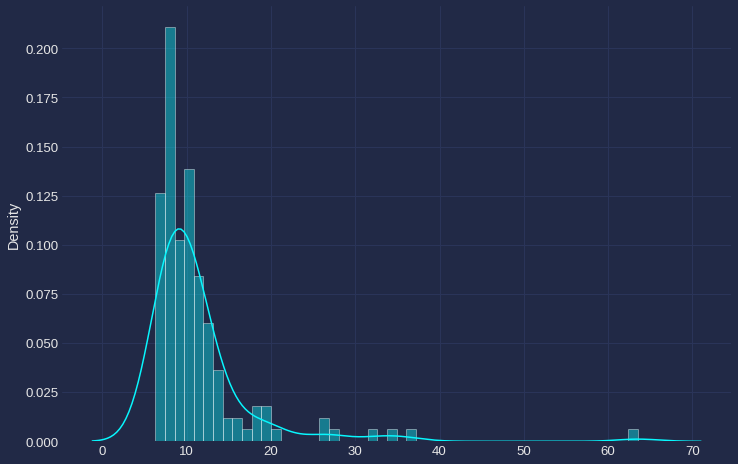

In [28]:
predictions, pred_losses = predict(test_normal_ds)
sns.distplot(pred_losses, bins=50, kde=True);

In [34]:
THRESHOLD = 26
# count the correct predictions
correct = sum(loss <= THRESHOLD for loss in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_ds)}')

Correct normal predictions: 139/145


### Anomalies

> Now we can take the predictions of our model for the subset anomalies.

- We'll do the same with the anomaly examples but their number is much higher. We'll get a subset that has the same size as the normal heartbeats

/home/ego/anaconda3/envs/finance/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


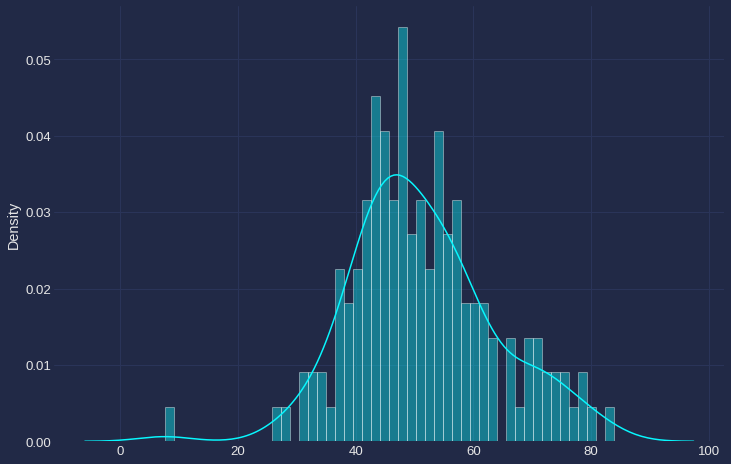

In [36]:
anomaly_ds = test_anomaly_ds[:len(test_normal_ds)]
predictions, pred_losses = predict(anomaly_ds)
sns.distplot(pred_losses, bins=50, kde=True);

In [37]:
# Finally, we can count the correct number of examples
# above the threshold (which are considered as anomalies)
correct = sum(loss > THRESHOLD for loss in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_ds)}')

Correct anomaly predictions: 144/145


> We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

- We can overlay the real and reconstructed *Time Series* values to see how close they are. We'll do it for both: normal and anomaly cases.

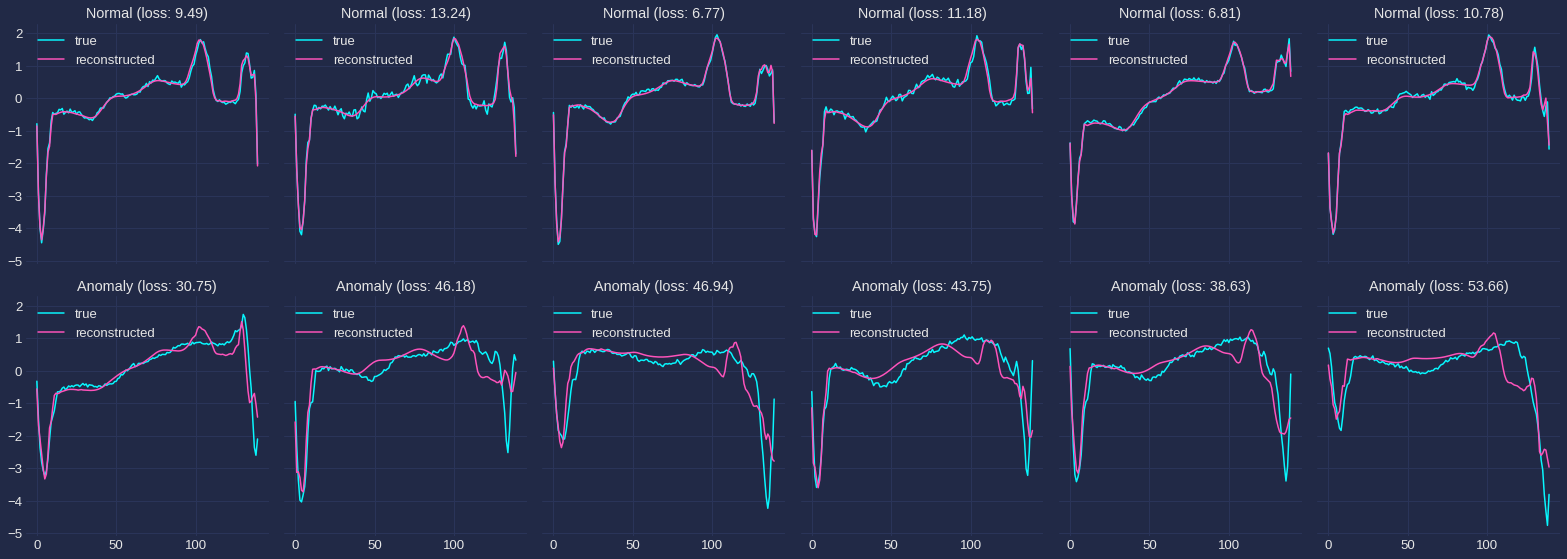

In [41]:
def plot_pred_(data, label, ax) -> None:
    preds, losses = predict([data])
    ax.plot(data, label='true')
    ax.plot(preds[0], label='reconstructed')
    ax.set_title(f'{label} (loss: {np.around(losses[0], 2)})')
    ax.legend()

ncols = 6
fig, axs = plt.subplots(
    nrows=2,
    ncols=ncols,
    sharey=True,
    sharex=True,
    figsize=(22, 8),
)
for i, data in enumerate(test_normal_ds[:ncols]):
    plot_pred_(data, label='Normal', ax=axs[0, i])
for i, data in enumerate(test_anomaly_ds[:ncols]):
    plot_pred_(data, label='Anomaly', ax=axs[1, i])
fig.tight_layout();

In [42]:
fig.savefig('real-vs-reconstructed.jpg')